In [1]:
import festim as F

my_model = F.Simulation()

Create a mesh with FEniCS

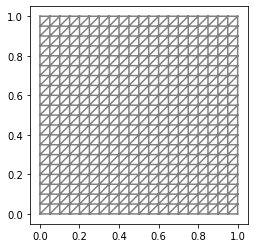

In [9]:
from fenics import UnitSquareMesh, CompiledSubDomain, MeshFunction, plot

# creating a mesh with FEniCS
nx = ny = 20
mesh_fenics = UnitSquareMesh(nx, ny)


# marking physical groups (volumes and surfaces)
volume_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim())
volume_markers.set_all(1)

tol = 1e-14

left_surface = CompiledSubDomain('on_boundary && near(x[0], 0, tol)',
                                tol=tol)
right_surface = CompiledSubDomain('on_boundary && near(x[0], 1, tol)',
                                     tol=tol)
bottom_surface = CompiledSubDomain('on_boundary && near(x[1], 0, tol)',
                                     tol=tol)
top_surface = CompiledSubDomain('on_boundary && near(x[1], 1, tol)',
                                     tol=tol)

surface_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)
surface_markers.set_all(0)
left_surface.mark(surface_markers, 1)
right_surface.mark(surface_markers, 2)
top_surface.mark(surface_markers, 3)
bottom_surface.mark(surface_markers, 3)

plot(mesh_fenics)

In [12]:
# creating mesh with FESTIM
my_model.mesh = F.Mesh(
    mesh=mesh_fenics,
    volume_markers=volume_markers,
    surface_markers=surface_markers
)

In [13]:
my_model.materials = F.Material(id=1, D_0=1, E_D=0)

my_model.T = F.Temperature(500)

my_model.boundary_conditions = [
    F.DirichletBC(surfaces=3, value=0),
    F.DirichletBC(surfaces=1, value=1)
    ]

my_model.settings = F.Settings(
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
    transient=False
    )

In [14]:
my_model.initialise()
my_model.run()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solved problem in 1.20 s


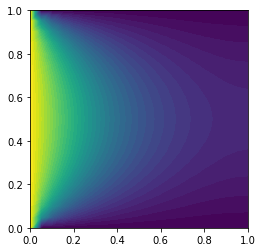

In [16]:
plot(my_model.h_transport_problem.mobile.solution)

In [30]:
my_model.initialise()

from fenics import inner, dot, grad, interpolate, Expression, VectorFunctionSpace

solute = my_model.h_transport_problem.mobile.solution
test_function_solute = my_model.h_transport_problem.mobile.test_function
functionspace = VectorFunctionSpace(my_model.mesh.mesh, "CG", 1)

velocity = interpolate(Expression(("-x[1]*(x[1] - 1)", "0"), degree=2), functionspace)

my_model.h_transport_problem.F += inner(
        dot(grad(solute), 100*velocity), test_function_solute
    ) * my_model.mesh.dx

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


In [31]:
my_model.run()

Solving steady state problem...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solved problem in 1.40 s


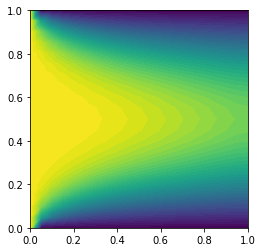

In [32]:
plot(my_model.h_transport_problem.mobile.solution)